<h1><center> ECE/CS 524  Introduction to Optimization Fall 2019 </center></h1>
<h2><center>Optimizing the distribution of donations among disaster affected areas</center></h2>
<h2><center> Yukiko Suzuki </center></h2>

<h3>Table of contents</h3>
<ol><li> 
    
[Introduction](#introduction)
    
</li>

<li>
    
[Helper Functions](#helper)

</li>

<li>
    
    
[Data](#data)
    
   <ul>
    <li>
        
   [Toy Example](#data_toy)
    </li>
     <li>
    
   [Case Study](#data_case)
   </li>
   </ul>    
<li>  
    
[Scenario 1](#s1)
    <ul>
    <li>
        
   [Mathematical Model](#s1math)
      
   </li>
   <li>
    
   [Toy Solution](#s1solutionToy)
    
   </li>
   
   <li>
    
   [Case Study Solution](#s1solutionCase)
    
   </li>
        
   </ul>
</li>
<li>  
    
[Scenario 2](#s2)
 <ul>
    <li>
        
   [Mathematical Model](#s2math)
      
   </li>
   <li>
    
   [Toy Solution](#s2solutionToy)
    
   </li>
   
   <li>
    
   [Case Study Solution](#s2solutionCase)
    
   </li>
        
   </ul>
</li>
<li>  
    
[Scenario 3](#s3)
    <ul>
    <li>
        
   [Mathematical Model](#s3math)
      
   </li>
   <li>
    
   [Toy Solution](#s2solutionToy)
    
   </li>
   
   <li>
    
   [Case Study Solution](#s2solutionCase)
    
   </li>
        
   </ul>
</li>

</ul>
<li>
    
[Solution](#solution)

</li>

<li>
    
[Result and Discussion](#result)

</li>

<li>
    
[Conclusion](#conclusion)

</li>


</ol>

<a id='introduction'></a>
                   
<h2>Introduction</h2>

In the past decades, the number and the impact of natural disasters have been increasing. In many cases, the affected people are forced to live with limited amount of necessary goods such as food and clothings. Fortunately, when an area is severely affected by a disaster, donations are given from other unaffected regions around the country.However, there is no single system which optimizes the distribution of the goods among the affected areas. This causes suboptimal allocations of donated goods. For instance, some affected areas may have to face shortage of goods while other affected areas may experience excess supply of the same goods. 
The goal of this project is to optimize the distribution of the donations among affected areas. More specifically, given the demand and supply of the donated goods, we aim to minimize the amount of total shortage and the total distance travelled to distribute these goods. There will be a trade off between the distance travelled and the amount of shortage in our problem.

Additionally, we would like to test how the result would change under these 3 different scenarios.
1) Supply side can distribute the goods to the demand side only directly. 2) Demand side can also act as a hub for the distribution(We allow demand side to be relay nodes). 3) We set distribution centers at some mid - points.

<a id='helper'></a>
<h2>helpr functions and Libraries</h2>

In [3]:
using IJulia, LinearAlgebra,PyPlot, CSV, JuMP, Gurobi,Statistics

IJulia.installkernel("Julia nodeps", "--depwarn=no")
# Plots the locations of demand and supply with size corresponding to the amount of supply or demand 
# Plots the locations of demand and supply with size corresponding to the amount of supply or demand 
function plot_setup()
    scatter(Dlocation[:,1],Dlocation[:,2],s=D[:]*50,color = "blue",label = "demand")
    scatter(Slocation[:,1],Slocation[:,2],s=S[:]*50,color = "red",label = "supply");
    scatter(Clocation[:,1],Clocation[:,2],s=D[:]*50,color = "yellow",label = "center")
    legend(loc = "best",fontsize=10, markerscale = 0.1)
end

# Plots the result of the optimization with each arrows corresponding to the flow of the donations
function plot_result() 
    for i in 1:s
        for j in 1:d
            if result[i,j] >= 0.0001 
                size = result2[i,j]/10
                dx = Slocation[i,1] - Dlocation[j,1] 
                dy = Slocation[i,2] - Dlocation[j,2] 
                arrow(Slocation[i,1],Slocation[i,2],-dx ,-dy, head_width=size*3, width=size,head_length=size,head_starts_at_zero="true",length_includes_head = "true",facecolor="white", alpha = 0.8)
            end
        end
    end
end




┌ Info: Installing Julia nodeps kernelspec in C:\Users\Owner\AppData\Roaming\jupyter\kernels\julia-nodeps-1.1
└ @ IJulia C:\Users\Owner\.julia\packages\IJulia\4UizY\deps\kspec.jl:72


plot_result (generic function with 1 method)

<a id = "data"></a>
<h2>Data</h2>

<a id = "data_toy"></a>
<h3>Data for Toy Example</h3>
We are going to show a very simple example of this optimization by setting the parameters and the locations by ourselves. 
These parameters are: 
<ol>
    <li>
    Locations of demand side    
   </li>
    <li>
    Locations of supply side    
   </li>
     <li>
    Locations of distribution center    
   </li>
    <li>
    Amount of goods needed at each demand side  
   </li>
     <li>
    Amount of goods supplied at each supply side  
   </li>
    <li>
      Capacity of each distribution center
   </li>
</ol>

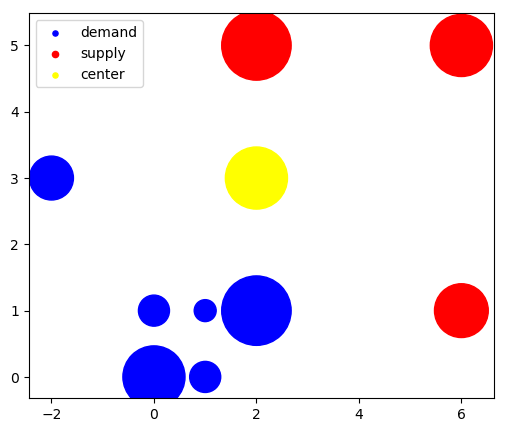

In [5]:

# Location of each demand side
Dlocation = [0 0;
             1 0;
             0 1;
             1 1;
            2 1
            -2 3];
# Location of each supply side
Slocation = [2 5;
            6 5
            6 1];
Clocation = [2 3]
# amount supplied at each supply side
S = [50;40;30]
# amount needed at each demand sides
D = [40;10;10;5;50; 20]
C = 100
Cost1 = 100;
s = size(Slocation,1);
d = size(Dlocation,1);
c = size(Clocation,1)
Distances = zeros(s,d);
DistancesX = zeros(d,d);
DistancesSC = zeros(s,c);
DistancesCX = zeros(c,d);

for i in 1:s
    for j in 1:d
        #distance between a supply side j and demand side i
        Distances[i,j] = norm(Slocation[i,:] - Dlocation[j,:])
    end
    for k in 1:c
        DistancesSC[i,k] = norm(Slocation[i,:] - Clocation[k,:])
    end
end

for i in 1:d
    for j in 1:d
        # pair wise distance among demand side i and j
        DistancesX[i,j] = norm(Dlocation[i,:] - Dlocation[j,:]) 
    end
    for k in 1:c
        DistancesCX[k,i] = norm(Clocation[k,:] - Dlocation[i,:])
    end
end



figure(figsize=(6,5))
plot_setup();


<a id = "data_case"></a>
<h2>Data for Case Study</h2>

For the case study, we target the situation of natural disasters in Japan in 2018. They had 2 major earthquakes in Osaka and Hokkaido area,  with magnitude of 6 and 6.7 respectively. More than 30,000 houses were destroyed by the earthquake. 
For this study, I choose the affected munincipalities with population more than 30,000 as the demand nodes, all the other unaffected areas with population more than 50,000 to be supply nodes. 

<h3>Locations</h3>
For the location of demand and supply side, we are going to use altitude and lattitude of the city councils.  

<h3>Demand</h3>
To estimate the amount of goods needed at each demand side, we are going to assume that the demand is proportional to the population of each munincipality.More specifically, we estimate the demand of a munincipality j to be one hundredth of its population.

<h3>Supply</h3>
We also assume that the supply from a munincipality i is proportional to its population. More specifically, we assume that the supply from each municipality is one thausandth of its population.

<h3>Distances</h3>
The distance between each nodes are calculted in advance so that the model can be treated as linear.


In [6]:

demandData = CSV.read("demand.csv",datarow=2);
supplyData = CSV.read("supply.csv",datarow=2);

Dlocation2 = convert(Array,demandData[:,1:2]);
Slocation2 = convert(Array,supplyData[:,1:2]);

Clocation2 = [34.3 134;
            36.39 138.1]
S2 = supplyData[:,3]/1000; 
D2 = demandData[:,3]/100;
C2 = [5000;3000]
s2 = size(Slocation2,1);
d2 = size(Dlocation2,1);
c2 = size(Clocation2,1);
cost2 = [10,10]
Distances2 = zeros(s2,d2);
DistancesX2 = zeros(d2,d2);
DistancesSC2 = zeros(s2,c2);
DistancesCX2 = zeros(c2,d2);
for i in 1:s2
    for j in 1:d2
        Distances2[i,j] = norm(Slocation2[i,:] - Dlocation2[j,:])
    end
    for k in 1:c2
        DistancesSC2[i,k] = norm(Slocation2[i,:] - Clocation2[k,:])
    end
end

for i in 1:d2
    for j in 1:d2
        DistancesX2[i,j] = norm(Dlocation2[i,:] - Dlocation2[j,:]) 
    end
    for k in 1:c2
        DistancesCX2[k,i] = norm(Dlocation2[i,:] - Clocation2[k,:])
    end
    
end



┌ Warning: `convert(::Type{Array}, df::AbstractDataFrame)` is deprecated, use `convert(Matrix, df)` instead.
│   caller = top-level scope at In[6]:4
└ @ Core In[6]:4
┌ Warning: `convert(::Type{Array}, df::AbstractDataFrame)` is deprecated, use `convert(Matrix, df)` instead.
│   caller = top-level scope at In[6]:6
└ @ Core In[6]:6


<h3><center>Affected cities and supplying cities</center></h3>
<img src="initial.png" />

<a id='s1'></a>
<h2>Scenario 1</h2>



<a id='s1math'></a>
<h3> Mixed Integer Program</h3>
We are going to apply Mixed Integer Programming models under 3 scenarios.
<h3>Assumptions</h3>
<ol>
    <li> There is only one type of donated goods </li>
    <li> No limit on the amout a track can carry</li>
</ol>
<h3> List of parameters </h3>
<ul>
    <li>
        Capacity: How much more can a demand side hold goods than its original amount of demand 
    </li>
    <li>
        $\lambda_1$: The cost of driving 100 km 
    </li>
    <li>
        $\lambda_2$: The penalty of having one unit of shortage
    </li>
        <li>
        $Dlocation_j$: (x,y) coordinate of location of a demand side j
    </li>
    <li>
        $Slocation_i$: (x,y) coordinate of location of a supply side i
    </li>
    <li>
        $D_j$: Amout of donation needed at a demande side j 
    </li>
    <li>
        $S_i$: Amout of donation available at a supply side i
    </li>
    <li>
        $Distance_{i,j}$: Euclidean distance from supply side i and demand side j 
    </li>
</ul>
<h3> List of variables </h3>
$x_{i,j} = $ The amout of donations from supply side i to demand side j (Integer)


$ bx_{i,j}= \begin{cases}
  0, & \text{if } x_{i,j} \le 0, \\
  1, & \text{otherwise}.
\end{cases}
$
<h3> List of constraints </h3>

<ol>
    <li>
        Total distribution from supply side i cannot exceed its initial supply $\sum_j x_{i,j} \le S_i$ for all i
     </li>
    <li>
        Each demand side j cannot recieve donation more than its capacity
        $\sum_i x_{i,j} < D[j]Capacity$
   </li>
   <li>
        Supply side can distribute donations to no more than 2 destinations
        $\sum_j bx_{i,j} \le 2$ for all supply side i
   </li>
</ol>
<h3> Objective function </h3>
We would like to MINIMIZE the total distance travelled and the amount of shortage


$\sum_{i,j} \lambda_1Distance_{i,j}bx_{i,j} + \lambda_2\sum_j shortage_j$

where $shortage_j = D_j - \sum_i x_{i,j}$


<h2> Standard Form</h2>
$
\begin{aligned}
\underset{x \in \mathbb{R^n}\\ bx \in {0,1}}{\text{minimize}}\qquad& \sum_{i,j} Distances_{i,j}bx_{i,j} + \lambda_2\sum_j shortage \\
\text{subject to:}\qquad& \sum_j x_{i,j} \le S_i && i=1,\dots,s\\
&\sum_i x_{i,j} < D_jCapacity && j=1,\dots,d\\
&\sum_j bx_{i,j} \le 2 && j=1,\dots,s
\end{aligned}
$



<a id='s1solutionToy'></a>
<h3> Toy Example Solution </ht3>

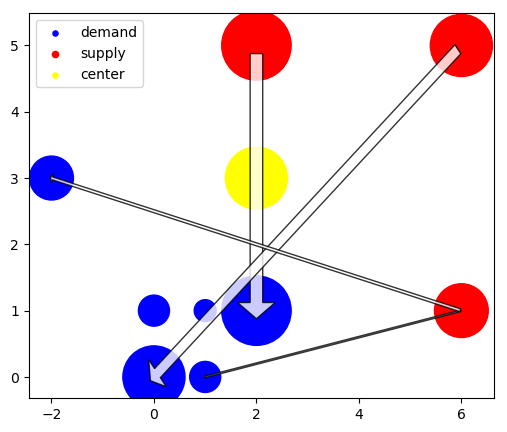

Academic license - for non-commercial use only


In [9]:

using Gurobi, JuMP,Statistics
function scenerio1_toy(lambda1, lambda2)
    m = Model(solver = GurobiSolver(OutputFlag = false));

    @variable(m,x[1:s,1:d]>=0);
    @variable(m,bx[1:s,1:d], Bin);

    for i in 1:s
        for j in 1:d
            # Setting binary if x >= 0 then bx = 1
            @constraint(m,x[i,j] <= 1000*bx[i,j])
        end
    end


    for i in 1:d
        # City i cannot recieve more than 100 % of its demand
        @constraint(m,sum(x[:,i]) <= D[i]*capacity)
    end

    for j in 1:s
        # Total Distribution from city i cannot exceed its supply
        @constraint(m, sum(x[j,:]) <= S[j])
        # Supply side can destribute no more than 2 destinations
        @constraint(m, sum(bx[j,i] for i in 1:d) <= 2)
    end

    # Minimizing the cost
    @objective(m, Min, lambda1*sum(Distances[i,j]*bx[i,j]  for i in 1:s, j in 1:d) + lambda2*sum(D[j] - x[i,j] for j in 1:d, i in 1:s ));
    solve(m);
    return [getvalue(x),getvalue(bx)];
end

capacity = 1
lambda1 = 0.1;
lambda2 = 2;
R = scenerio1_toy(lambda1, lambda2);
result = R[1]
bx = R[2]
average = sum(result)/ sum(size(result));;
result2 = sqrt.((result .- average).^2)./std(result);
distance = sum(Distances[i,j]*bx[i,j] for i in 1:s, j in 1:d);
shortage = sum(D[j] - result[i,j] for j in 1:d, i in 1:s )
# Plotting the result
figure(figsize=(6,5))
plot_setup();
plot_result();


In [14]:
println("Total distance: ",distance);
println("Total shortage: ", shortage)

Total distance: 25.155480440734763
Total shortage: 284.9999999999999


<a id ="s1solutionCase"></a>
<h2>Case Study Solution</h2>

In [155]:
function scenerio1_case(lambda1, lambda2)
    capacity = 1
    M = 100000000
    m = Model(solver = GurobiSolver(OutputFlag = false));

    @variable(m,x[1:s2,1:d2]>=0);
    @variable(m,bx[1:s2,1:d2], Bin);
    @variable(m,shortage[1:d2]);
    for i in 1:s2
        for j in 1:d2
            # Setting binary if x >= 0 then bx = 1
            @constraint(m,x[i,j] <= M*bx[i,j])
        end
    end


    for i in 1:d2
        # City i cannot recieve more than 100 % of its demand
        @constraint(m,sum(x[:,i]) <= D2[i]*capacity)
        # Defining shortage
        @constraint(m,shortage[i] == D2[i] - sum(x[j,i] for j in 1:s2))
    end

    for j in 1:s2
        # Total Distribution from city i cannot exceed its supply
        @constraint(m, sum(x[j,:]) <= S2[j])
        # Supply side can destribute no more than 2 destinations
        @constraint(m, sum(bx[j,i] for i in 1:d2) <= 2)
    end
    
    
    # Minimizing the cost
    @objective(m, Min, lambda1*sum(Distances2[i,j]*bx[i,j]  for i in 1:s2, j in 1:d2) + lambda2*sum(shortage));
    solve(m)
    return [getvalue(x),getvalue(bx),getvalue(shortage)];
end
lambda1 = 0.1;
lambda2 = 2;
R = scenerio1_case(lambda1,lambda2)
result = R[1];
bx = R[2]
shortage = R[3]
average = sum(result)/ sum(size(result));;
result2 = sqrt.((result .- average).^2)./std(result);
using DelimitedFiles
writedlm("s1.csv", result, ", ")
total_shortage = sum(shortage)
total_distance = sum(Distances2[i,j]*bx[i,j]  for i in 1:s2, j in 1:d2);


Academic license - for non-commercial use only


<h3><center>Resulting distribution under scenerio 1 </center></h3>
<img src="s1.png" />
Green line represents the flow of goods from each supply side to demand side


In [156]:
println("Total shortage is: ", total_shortage);
println("Total distance is: ", total_distance);

Total shortage is: 33035.531
Total distance is: 132.8673808873719


<a id='s2'></a>
<h2>Scenerio 2</h2>

<a id='s2math'></a>
<h2>Mathematical Model</h2>
We are making modification to the scenerio 1 by making the demand side also relay nodes.
Again, this is MIXED INTEGER PROGRAMMING
<h3>Assumptions</h3>
<ol>
    <li> There is only one type of donated goods </li>
    <li> No limit on how much a truck can carry </li>
</ol>
<h3> List of parameters </h3>
<ul>
    <li>
        Capacity: How much more can a demand side hold goods than its original amount of demand 
    </li>
    <li>
        $\lambda_1$: The cost of driving 100 km 
    </li>
    <li>
        $\lambda_2$: The penalty of having one unit of shortage
    </li>
        <li>
        $Dlocation_j$: (x,y) coordinate of location of a demand side j
    </li>
    <li>
        $Slocation_i$: (x,y) coordinate of location of a supply side i
    </li>
    <li>
        $D_j$: Amout of donation needed at a demande side j 
    </li>
    <li>
        $S_i$: Amout of donation available at a supply side i
    </li>
    <li>
        $Distance_{i,j}$: Eucledean distance from demand side j ato supply side i
    </li>
    <li>
    <font color = "blue">$DistanceX_{l,k}$ Eucledean distance from demand side l to demand side k</font>
    </li>
</ul>
<h3> List of variables </h3>
$x_{i,j} = $ The amout of donations from supply side i to demand side j (Integer)

<font color="blue">$xd_{i,j} = $ The amount of donations travelled from demand side i to another demand side j</font>


$ bx_{i,j}= \begin{cases}
  0, & \text{if } x_{i,j} \le 0, \\
  1, & \text{otherwise}.
\end{cases}
$



<font color="blue">$ bxd_{i,j}= \begin{cases}
  0, & \text{if } xd_{i,j} \le 0, \\
  1, & \text{otherwise}.
\end{cases}
$</font>
<h3> List of constraints </h3>

<ol>
    <li>
        Total distribution from supply side i cannot exceed its initial supply $\sum_j x_{i,j} \le S_i$ for all i
     </li>
    <li>
        Each demand side j cannot recieve donation more than its capacity
        $\sum_i x_{i,j}+$<font color = "blue">$\sum_i xd_{i,j}$</font>$\le CapacityD_j$
   </li>
   <li>
        Supply side can distribute donations to no more than 2 destinations
        $\sum_j bx_{i,j} \le 2$ for all supply side i
   </li>
   <li>
        <font color = "blue">Demand side can redistribute donations to no more than 2 destinations
        $\sum_j bxd_{i,j} \le 2$ for all supply side i</font>
   </li>
   <li>
        <font color = "blue">Each demand node cannot redistribute more than the amount predistributed to them $\sum_i xd_{i,j} \le \sum_j xd_{i,j} + \sum_j x_{i,j}$  </font>
   </li>
</ol>
<h3> Objective function </h3>
Minimize the total distance travelled(from supply node to demand node AND demand node to demand node)

$\sum_{i,j} \lambda_1(Distance_{i,j}bx_{i,j} + DistanceX_{l,k}bdx_{l,k}) + \lambda_2\sum_j shortage_j$

where $shortage_j = D_j - \sum_i x_{i,j}$ - <font color = "blue">$\sum_{i,j} xd_{i,j}$</font>

$DistanceX_{l,k}$ is the distance between two demand sides l and k

<h2> Standard Form</h2>
$
\begin{aligned}
\underset{x,xd \in \mathbb{R^n}\\ bx,bxd \in {0,1}}{\text{minimize}}\qquad& \sum_{i,j} Distances_{i,j}bx_{i,j} + \sum_{i,j} DistancesX_{l,k}bxd_{l,k} + \lambda_2\sum_j shortage \\
\text{subject to:}\qquad& \sum_j x_{i,j} \le S_i && i=1,\dots,s\\
&\sum_i x_{i,j} + \sum_i xd_{i,j} < D_jCapacity && j=1,\dots,d\\
&\sum_j bx_{i,j} \le 2 && j=1,\dots,s\\
&\sum_j bxd_{i,j} \le 2&& i=1,\dot,s\\
&\sum_i xd_{i,j} \le \sum_j xd_{i,j} + \sum_j x_{i,j}&& j=1,\dot,d\\
\end{aligned}
$



<a id ="s2solutionToy"> </a>
<h2>Solution for Toy Problem </h2>

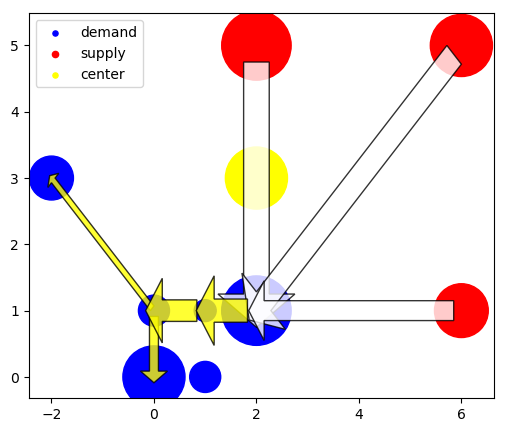

Academic license - for non-commercial use only


In [11]:
function scenerio2_toy(lambda1,lambda2)
    s = size(Slocation,1)
    d = size(Dlocation,1)
    capacity = 1
    m = Model(solver = GurobiSolver(OutputFlag=false));
    @variable(m,x[1:s,1:d]>=0);
    @variable(m,bx[1:s,1:d]>=0,Bin);

    @variable(m,xd[1:d,1:d]>=0);
    @variable(m,bxd[1:d,1:d]>=0,Bin);

    @variable(m,net[1:d]);

    # City i cannot recieve more than 110 % of its demand
    for i in 1:d
        # The net amount given cannot exceed the capacity*demand
        @constraint(m,sum(x[:,i]) + sum(xd[:,i]) - sum(xd[i,:]) <= D[i]*capacity)
        # cannot give it to your self
        @constraint(m, xd[i,i] == 0);
        #Each demand city cannot provide more than it has recieved from supply and other demand nodes
        @constraint(m, sum(xd[i,:]) <= sum(x[:,i]) + sum(xd[:,i]))
        #Setting net amount flow between demand cities.
        @constraint(m,net[i] == sum(xd[:,i]) - sum(xd[i,:]));
        # can only pass to only 2 locations from demand side
        @constraint(m,sum(bxd[i,:]) <= 2)
        for j in 1:s
             # Setting binary if x >= 0 then bx = 1
            @constraint(m,x[j,i] <= 1000*bx[j,i])
        end
        for j in 1:d
            # Setting binary if xd >= 0 then bxd = 1
            @constraint(m,xd[j,i] <= 1000*bxd[j,i])
        end  
    end

    # Cannot exceed its supply for distribution
    for j in 1:s
        @constraint(m, sum(x[j,:] ) <= S[j])
        @constraint(m,sum(bx[j,:]) <= 2)

    end

    @objective(m, Min, lambda1*(sum(Distances[i,j]*bx[i,j] for i in 1:s, j in 1:d) + sum(DistancesX[i,j]*bxd[i,j] for i in 1:d, j in 1:d))+
        lambda2*(sum(D - sum(x[i,:] for i in 1:s)) + sum(net[i] for i in 1:d) ));
    solve(m)
    return [getvalue(x), getvalue(xd),getvalue(net),getvalue(bx),getvalue(bxd)]
end
lambda1 = 0.1;
lambda2 = 1;
R = scenerio2_toy(lambda1,lambda2);
result = R[1];
x = result
result2 = R[2];
xd = result2
bx = R[4];
bxd = R[5]
distance = sum(bxd[i,j]*DistancesX[i,j] for i in 1:d,j in 1:d) + sum(bx[i,j]*Distances[i,j] for i in 1:s, j in 1:d);
shortage = sum(D - sum(x[i,:] for i in 1:s) - sum(xd[i,:] for i in 1:d))
# Plotting the result
figure(figsize=(6,5))
plot_setup();

for i in 1:s
    for j in 1:d
        if result[i,j] >= 0.0001 
            size = result[i,j]/100
            dx = Slocation[i,1] - Dlocation[j,1] 
            dy = Slocation[i,2] - Dlocation[j,2] 
            arrow(Slocation[i,1],Slocation[i,2],-dx ,-dy, head_width=size*3, width=size,head_length=size,head_starts_at_zero="true",length_includes_head = "true",facecolor="white", alpha = 0.8)
        end
    end
end

for i in 1:d
    for j in 1:d
        if result2[i,j] >= 0.0001 
            size = result2[i,j]/200
            dx = Dlocation[i,1] - Dlocation[j,1] 
            dy = Dlocation[i,2] - Dlocation[j,2] 
            arrow(Dlocation[i,1],Dlocation[i,2],-dx ,-dy, head_width=size*3, width=size,head_length=size,head_starts_at_zero="true",length_includes_head = "true",facecolor="yellow", alpha = 0.8)
        end
    end
end

In [12]:
println("total distance: ", distance);
println("total shortage: ", shortage)

total distance: 19.485281374238568
total shortage: -175.0


<a id ="s2solutionCase"> </a>
<h2>Solution for Toy Problem </h2>

In [13]:
function scenerio2Case(lambda1,lambda2)
    capacity = 1
    M = 1000000;
    m = Model(solver = GurobiSolver(OutputFlag=false));
    @variable(m,x[1:s2,1:d2]>=0,Int);
    @variable(m,bx[1:s2,1:d2]>=0,Bin);

    @variable(m,xd[1:d2,1:d2]>=0,Int);
    @variable(m,bxd[1:d2,1:d2]>=0,Bin);

    @variable(m,net[1:d2]);

    # cannot give it to your self
    # City i cannot recieve more than 110 % of its demand
    for i in 1:d2
        # The net amount given cannot exceed the capacity*demand
        @constraint(m,sum(x[:,i]) + sum(xd[:,i]) - sum(xd[i,:]) <= D2[i]*capacity)
        # cannot give it to your self
        @constraint(m, xd[i,i] == 0);
        #Each demand city cannot provide more than it has recieved from supply and other demand nodes
        @constraint(m, sum(xd[i,:]) <= sum(x[:,i]) + sum(xd[:,i]))
        #Setting net amount flow between demand cities.
        @constraint(m,net[i] == sum(xd[:,i]) - sum(xd[i,:]));
        # can only pass to two locations from demand side
        @constraint(m,sum(bxd[i,:]) <= 2)

        for j in 1:s2
             # Setting binary if x >= 0 then bx = 1
            @constraint(m,x[j,i] <= M*bx[j,i])
            @constraint(m,x[j,i] >= -1*(1-bx[j,i]) + bx[j,i])
        end
        for j in 1:d2
            # Setting binary if xd >= 0 then bxd = 1
            @constraint(m,xd[j,i] <= M*bxd[j,i])
            @constraint(m,xd[j,i] >= -1*(1-bxd[j,i]) + bxd[j,i])
        end  
    end

    # Cannot exceed its supply for distribution
    for j in 1:s2
        @constraint(m, sum(x[j,:] ) <= S2[j])
        @constraint(m,sum(bx[j,:]) <= 2)
    end

    @objective(m, Min, lambda1*(sum(Distances2[i,j]*bx[i,j] for i in 1:s2, j in 1:d2) + sum(DistancesX2[i,j]*bxd[i,j] for i in 1:d2, j in 1:d2))+
        lambda2*(sum(D2 - sum(x[i,:] for i in 1:s2)) - sum(net[i] for i in 1:d2) ));
    solve(m)
    return [getvalue(x),getvalue(xd),getvalue(net),getvalue(bx),getvalue(bxd)]
end
lambda1 = 0.1;
lambda2 = 1;
result = scenerio2Case(lambda1,lambda2)
x = result[1]
xd =result[2]
net = result[3]
bx = result[4];
bxd = result[5]
writedlm("s2x.csv", x, ", ");
writedlm("s2xd.csv", xd, ", ")

Academic license - for non-commercial use only


UndefVarError: UndefVarError: writedlm not defined

┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = close_figs() at PyPlot.jl:130
└ @ PyPlot C:\Users\Owner\.julia\packages\PyPlot\mQXSC\src\PyPlot.jl:130


<h3><center>Resulting distribution under scenerio 2 </center></h3>
<h4>green line represents flow from suppy to demand.</h4>
<h4>black line represents flow from demand to demand</h4>
<img src="s2.png" />


In [158]:
println("Total shortage is: ", sum(D2 - sum(x[i,:] for i in 1:s2) -net))
println("Total distance travelled is: ",sum(Distances2[i,j]*bx[i,j] for i in 1:s2, j in 1:d2) + sum(DistancesX2[i,j]*bxd[i,j] for i in 1:d2, j in 1:d2))

Total shortage is: 33052.15
Total distance travelled is: 116.58557504175587


<a id='s3'></a>
<h2>Scenario 3</h2>

<a id='s3math'></a>
We are going to make modification to scenario 1 and create 2 distribution centers.Note that there is fixed cost to using each distrubition centers 
<h3>Assumptions</h3>
<ol>
    <li> There is only one type of donated goods </li>
    <li> No limit on the amount each truck can carry</li>
</ol>
<h3> List of parameters </h3>
<ul>
    <li>
        Capacity: How much more can a demand side hold goods than its original amount of demand 
    </li>
    <li>
        $\lambda_1$: The cost of driving 100 km 
    </li>
    <li>
        $\lambda_2$: The penalty of having one unit of shortage
    </li>
        <li>
        $Dlocation_j$: (x,y) coordinate of location of a demand side j
    </li>
    <li>
        $Slocation_i$: (x,y) coordinate of location of a supply side i
    </li>
     <li>
        <font color = "blue">$Clocation_k$: (x,y) coordinate of location of a distribution center k</font>
    </li>
    <li>
        $D_j$: Amout of donation needed at a demande side j 
    </li>
    <li>
        $S_i$: Amout of donation available at a supply side i 
    </li>
    <li>
        <font color = "blue">$C_k$: Capacity at center k </font>
    </li>
    <li>
        <font color = "blue">$FixedCost_k$: Fixed cost of using the center k </font>
    </li>
    <li>$Distance_{i,j}$ Eucledean distance from a node i to node j</li>

</ul>
<h3> List of variables </h3>
$x_{i,j} = $ The amout of donations from supply side i to demand side j (Integer)

$ bx_{i,j}= \begin{cases}
  0, & \text{if } x_{i,j} \le 0, \\
  1, & \text{otherwise}.
\end{cases}$


<font color = "blue">$cx_{k,j} = $ The amout of donations from distribution k to demand side j (Integer) </font>


<font color = "blue">$ bcx_{k,j}= \begin{cases}
  0, & \text{if } cx_{i,j} \le 0, \\
  1, & \text{otherwise}.
\end{cases}$</font>

<font color = "blue">$sc_{i,k} = $ The amout of donations from supply i to distribution side k (Integer)$ </font>


<font color = "blue">$ bsc_{i,j}= \begin{cases}
  0, & \text{if } sc_{i,k} \le 0, \\
  1, & \text{otherwise}.
\end{cases}$</font>

<font color = "blue">$ fixed_{k}= \begin{cases}
  0, & \text{if } \sum_i sc_{i,k} \le 0, \\
  1, & \text{otherwise}.
\end{cases}$</font>
<h3> List of constraints </h3>

<ol>
    <li>
        Total distribution from supply side i cannot exceed its initial supply $\sum_j x_{i,j}$<font color = "blue"> $+\sum_{k}sc_{i,k}$</font>$\le S_i$ for all i
    </li>
    <li>
        Each demand side j cannot recieve donation more than its capacity
       $\sum_i x_{i,j}+$<font color = "blue">$\sum_k cx_{k,j}$</font>$\le CapacityD_j$
   </li>
   <li>
        Supply side can distribute donations to no more than 2 destinations
        $\sum_j bx_{i,j} \le 2$ for all supply side i
   </li>
    <li>
        <font color = "blue">Distribution centers can distribute donations to no more than 2 destinations
        $\sum_j bcx_{k,j} \le 2$ for all distribution center k</font>
   </li>
   <li>
        <font color = "blue">The amount distribution centers can distribute is no more than what is predistributed by the supply sides
        $\sum_i sc_{i,k} \le \sum_j cx_{k,j}$ for all distribution center k</font>
   </li>
   <li>
        <font color = "blue">The amount distribution centers can recieve should not exceed its capacity
        $\sum_i sc_{i,k} \le C_k$ for all distribution center k</font>
   </li>
</ol>
<h3> Objective function </h3>

MINIMIZE the total distance travelled

(Supply node to Demand node AND Supply node to Distribution Center AND Disribution Center to Demand Node)


AND the amount of shortage and fixed cost of using each distribution center

$\lambda_1(\sum_{i,j} Distance(i,j)bx_{i,j} + \sum_{i,k}Distance(i,k)bsc_{i,k} + \sum_{k,j}Distance(k,j)bcx_{k,j})) + \lambda_2\sum_j shortage_j +$ <font color = "blue">$\sum_k FixedCost_kfixed_k$</font>

where $shortage_j = D_j - \sum_i x_{i,j} - \sum_k cx_{k,j}$

<h2> Standard Form</h2>
$
\begin{aligned}
\underset{x,cx,sc \in \mathbb{R^n}\\ bx,bcx,bsc \in {0,1}}{\text{minimize}}\qquad& \sum_{i,j} Distances_{i,j}bx_{i,j} + Distances_{i,k}bsc_{i,k} + Distances_{k,j}bx_{k,j} \lambda_2\sum_j shortage \\
\text{subject to:}\qquad& \sum_j x_{i,j} +\sum_{k}sc_{i,k}\le S_i && i=1,\dots,s\\
&\sum_i x_{i,j} + \sum_k cx_{k,j} < D_jCapacity && j=1,\dots,d\\
&\sum_j bx_{i,j} \le 2 && j=1,\dots,s\\
&\sum_j bcx_{k,j} \le 2&& k=1 \dots,c\\
&\sum_i bsc_{i,k} \le 2&& i=1 \dots,s\\ 
&\sum_i sc_{i,k} \le C_k&& i=1 \dots,k\\                                               
\end{aligned}
$

<a id ="s3solutionToy"> </a>
<h2>Solution for Toy Problem </h2>

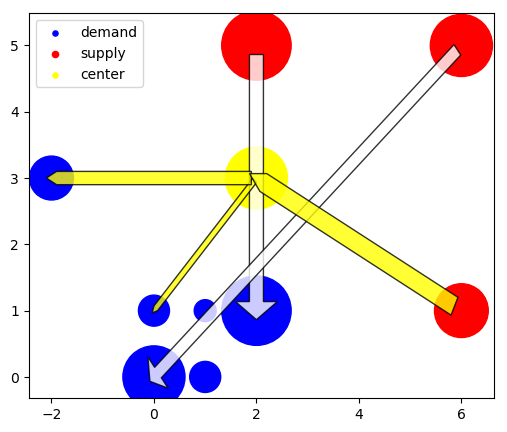

Academic license - for non-commercial use only


In [97]:
using Gurobi, JuMP,Statistics


function scenario3_toy(lambda1,lambda2)
    capacity = 1;
    Cost1 = 0.1
    m = Model(solver = GurobiSolver(OutputFlag = false));

    @variable(m,x[1:s,1:d]>=0);
    @variable(m,bx[1:s,1:d], Bin);

    @variable(m,cx[1:c,1:d] >= 0);
    @variable(m,bcx[1:c,1:d], Bin);

    @variable(m,sc[1:s,1:c]>=0);
    @variable(m,bsc[1:s,1:c], Bin);
    @variable(m,fixed[1:c],Bin);

    for i in 1:d
        for j in 1:s
             # Setting binary if x >= 0 then bx = 1
            @constraint(m,x[j,i] <= 1000*bx[j,i])    
        end

        for k in 1:c 
        # Setting binary if cx >= 0 then bcx = 1
            @constraint(m,cx[k,i] <= 1000*bcx[k,i])
        end
    end


    for i in 1:s
        for k in 1:c
            # Setting binary if sc >= 0 then bsx = 1
            @constraint(m,sc[i,k] <= 1000*bsc[i,k])
        end
    end

    for k in 1:c
        #centers can distribute donatons to no more than 2 destinations
        @constraint(m,sum(bcx[k,:]) <= 2)  
        # center can only distribute no more than it has recieved
        @constraint(m,sum(cx[k,:]) <= sum(sc[:,k]))
        # Each center can only recieve under its capacity
        @constraint(m,sum(sc[:,k]) <= C[k]);

        ## fixed is 0 if the center k is not used
        @constraint(m,sum(bsc[:,k]) - 1 <= 10000*fixed[k] - (1-fixed[k]))
    end


    for i in 1:d
        # City i cannot recieve more than 100 % of its demand
        @constraint(m,sum(x[:,i]) + sum(cx[:,i]) <= D[i]*capacity)
    end

    for j in 1:s
        # Total Distribution from city i cannot exceed its supply
        @constraint(m, sum(x[j,:]) + sum(sc[j,:]) <= S[j])
        # Supply side can destribute no more than  2 destinations
        @constraint(m, sum(bx[j,:]) <= 2)
    end

    # Minimizing the cost
    @objective(m, Min, lambda1*(sum(Distances[i,j]*bx[i,j]  for i in 1:s, j in 1:d) + sum(DistancesSC[j,k]*bsc[j,k] for j in 1:s, k in 1:c) 
            + sum(DistancesCX[k,i]*bcx[k,i] for k in 1:c, i in 1:d))
            + lambda2*(sum(D - sum(x[i,:] for i in 1:s) - sum(cx[k,:] for k in 1:c )))
            + sum(Cost1*fixed[k] for k in 1:c));
    solve(m)
    return [getvalue(x), getvalue(cx), getvalue(sc),getvalue(bsc),getvalue(bcx),getvalue(bx)]
end
lambda1 = 0.1;
lambda2 = 1;
R = scenario3_toy(lambda1,lambda2)
result = R[1]
resultSC = R[3]
resultCX = R[2]
bsc = R[4];
bcx = R[5]
bx = R[6]
distance = sum(Distances[i,j]*bx[i,j]  for i in 1:s, j in 1:d) 
            + sum(DistancesSC[j,k]*bsc[j,k] for j in 1:s, k in 1:c) 
            + sum(DistancesCX[k,i]*bcx[k,i] for k in 1:c, i in 1:d);
shortage = sum(D - sum(result[i,:] for i in 1:s) - sum(resultCX[k,:] for k in 1:c ))
average = sum(result)/ sum(size(result));;
result2 = sqrt.((result .- average).^2)./std(result);
# Plotting the result
figure(figsize=(6,5))
plot_setup();


for i in 1:s
    for j in 1:d
        if result[i,j] >= 0.0001 
            size = result2[i,j]/10
            dx = Slocation[i,1] - Dlocation[j,1] 
            dy = Slocation[i,2] - Dlocation[j,2] 
            arrow(Slocation[i,1],Slocation[i,2],-dx ,-dy, head_width=size*3, width=size,head_length=size,head_starts_at_zero="true",length_includes_head = "true",facecolor="white", alpha = 0.8)
        end
    end
end

for i in 1:c
    for j in 1:d
        if resultCX[i,j] >= 1
            size = resultCX[i,j]/100
            dx = Clocation[i,1] - Dlocation[j,1] 
            dy = Clocation[i,2] - Dlocation[j,2] 
            arrow(Clocation[i,1],Clocation[i,2],-dx ,-dy, head_width=size, width=size,head_length=size,head_starts_at_zero="true",length_includes_head = "true",facecolor="yellow", alpha = 0.8)
        end
    end
end

for k in 1:c
    for j in 1:s
        if resultSC[j,k] >= 1
            size = resultSC[j,k]/100
            dx = Slocation[j,1] - Clocation[k,1] 
            dy = Slocation[j,2] - Clocation[k,2] 
            arrow(Slocation[j,1],Slocation[j,2],-dx ,-dy, head_width=size, width=size,head_length=size,head_starts_at_zero="true",length_includes_head = "true",facecolor="yellow", alpha = 0.8)
        end
    end
end


In [1]:
println("Total shortage: ",shortage)
println("Total distance: ", distance)


UndefVarError: UndefVarError: shortage not defined

<a id ="s3solutionCase"> </a>
<h2>Solution for Case Problem </h2>

In [159]:
using Gurobi, JuMP,Statistics
function scenerio3Case(lambda1, lambda2)
    cost2 = [0.01; 0.00001]
    s = s2;
    d = d2;
    c = c2
    D = D2
    S = S2;
    C = C2;
    M =1000000;
    capacity = 1
    m = Model(solver = GurobiSolver(OutputFlag = false));

    @variable(m,x[1:s,1:d]>=0);
    @variable(m,bx[1:s,1:d], Bin);

    @variable(m,cx[1:c,1:d] >= 0);
    @variable(m,bcx[1:c,1:d], Bin);

    @variable(m,sc[1:s,1:c]>=0);
    @variable(m,bsc[1:s,1:c], Bin);
    @variable(m,fixed[1:c],Bin);


    for i in 1:d
        for j in 1:s
             # Setting binary if x >= 0 then bx = 1
            @constraint(m,x[j,i] <= M*bx[j,i])
            #@constraint(m,x[j,i] >= -1*(1-bx[j,i]) + bx[j,i])    
        end

        for k in 1:c 
        # Setting binary if cx >= 0 then bcx = 1
            @constraint(m,cx[k,i] <= M*bcx[k,i])
            #@constraint(m,cx[k,i] >= -1*(1-bcx[k,i]) + bcx[k,i])    
        end
    end


    for i in 1:s
        for k in 1:c
            # Setting binary if sc >= 0 then bsx = 1
            @constraint(m,sc[i,k] <= M*bsc[i,k])
            #@constraint(m,sc[i,k] >= -1*(1-bsc[i,k]) + bsc[i,k]) 
        end
    end

    for k in 1:c
        #centers can distribute donatons to no more than 2 destinations
        @constraint(m,sum(bcx[k,:]) <= 2)  
        # center can only distribute no more than it has recieved
        @constraint(m,sum(cx[k,:]) == sum(sc[:,k]))
        @constraint(m,sum(sc[:,k]) <= C[k]);

        ## fixed is 1 if the center k is used
        @constraint(m,sum(bsc[:,k]) - 1 <= M*fixed[k] - (1-fixed[k]))
    end


    for i in 1:d
        # City i cannot recieve more than 100 % of its demand
        @constraint(m,sum(x[:,i]) + sum(cx[:,i]) <= D[i]*capacity)
    
    end

    for j in 1:s
        # Total Distribution from city i cannot exceed its supply
        @constraint(m, sum(x[j,:]) + sum(sc[j,:]) <= S[j])
        # Supply side can destribute no more than  2 destinations
        @constraint(m, sum(bx[j,:]) <= 2)
    end


    # Minimizing the cost
    @objective(m, Min, lambda1*(sum(Distances2[i,j]*bx[i,j]  for i in 1:s, j in 1:d) + sum(DistancesSC2[j,k]*bsc[j,k] for j in 1:s, k in 1:c) 
            + sum(DistancesCX2[k,i]*bcx[k,i] for k in 1:c, i in 1:d))
            + lambda2*(sum(D2 - sum(x[i,:] for i in 1:s) - sum(cx[k,:] for k in 1:c )))
            + sum(cost2[k]*fixed[k] for k in 1:c));
    solve(m)
    return [getvalue(x),getvalue(sc),getvalue(cx),getvalue(bcx),getvalue(bsc),getvalue(bx)];
end

lambda1 = 0.1;
lambda2 = 1;
R = scenerio3Case(lambda1,lambda2);
result = R[1]
resultSC = R[2]
resultCX = R[3];
bcx = R[4];
bsc = R[5];
bx = R[6];
writedlm("s3x.csv", result, ", ");
writedlm("s3sc.csv", resultSC, ", ")
writedlm("s3cx.csv", resultCX, ", ")

shortage = sum(D2 - sum(result[i,:] for i in 1:s2) - sum(resultCX[k,:] for k in 1:c2));
distance = sum(Distances2[i,j]*bx[i,j]  for i in 1:s2, j in 1:d2) + sum(DistancesSC2[j,k]*bsc[j,k] for j in 1:s2, k in 1:c2) 
            + sum(DistancesCX2[k,i]*bcx[k,i] for k in 1:c2, i in 1:d2);

Academic license - for non-commercial use only


In [168]:
println("total shortage: ", shortage);
println("total distance: ", distance)


total shortage: 33035.530999999995
total distance: 112.55070653181873


<h3><center>Resulting distribution under scenerio 3 </center></h3>
<h4>black line represents from from supply to distribution center</h4>
<h4>red line represents from distribution centers to demand node </h4>
<img src="s3.png" />

<a id='result'></a>
<h2>Result and Discussion</h2>
First of all, we will review the result from the optimizations under 3 different scenarios.
Then, we will discuss the limitations of our models
<h2> Case Study</h2>


|     *  | Scenario 1   |Scenario 2| Scenario 3|
|--------|--------------|----------|-----------|
|shortage| 33035.53     | 33052.15 | 33035.53  |
|distance| 132.86       |116.58    | 112.55    |

We can see that the the amount of shortage is lowest under the scenario3 and scenario2. The distance is the shortest under the scenario3. Under the assumption we have set, scenario 3 seems to be the best option for us.

### Scenario1
Supply side tend to send their donations to the closest demand nodes


### Scenario2
We can see that now the flows from the supply nodes are more concentrated on the flow to the closer demand nodes. However, the demand node which attracted more donations is now passing some of its donations to the other demand node with greater shortage.


### Scenario3
As we look closely at the resulting flow of the donations on the map, under the scenario 3, there are multiple small supplying munincipalities sending their donations to the nearest distribution center.And each distribution which collected some donations then send large amount of donations to their closest demand nodes. This way, we can reduce the total distance travelled without increasing shortage.


<h2>Limitations</h2>
We have made a few strong assumptions such as each truck not having limit of its capacity. This may not be a problem if the flow of the goods are anyways under the capacity. However, in real life, such assumption would not hold. 

Additionally, we estimated the amount of demand and supply from the population. Such estimation may not be accurate in real life.

Finally, we took the euclidean distance between each nodes. Thus , some of the route go over the ocean. It may be more useful if we take the distance of the actual routes.

<img src="s1.png" style="width:400px;height:400px;" align = "right"/>
<img src="s2.png" style="width:400px;height:400px;" aligh = "left" />




<img src="s3.png" style="width:400px;height:400px;" align="left"/>
<img src="s3_complete.png" style="width:400px;height:400px;" align="right"/>





<a id='conclusion'></a>
<h2>conclusion</h2>

Overall, we have managed to solve the distribution problem under a few assumptions  for a toy example with self-genarated data. We also solved the problem with the real location and population data for the case study. From scenario 2 and 3, we added more complexities to the model in order to treat the sink node as relay node(for scenario 2) and to have a few distribution centers. Although we seeemed to have added constraints for the scenarios 2 and 3, our solution improved. This is because expecially for the scenario 2, we are relaxing a constraint by treating a sink node as a relay node. Also, by adding distribution centers to our model, we are adding more freedom to the direction of the flow of the goods.


There are few assumptions we would like to consider with more care, such as the estimation of the demand and supply. As we just estimated the demand and supply from the raw population in these regions, the estimation may be not as accurate. It would be more helpful if we could get more information on the how many people. Another assumption we have made is that there is no limit on how much a truck can carry the goods. Thus, in our model, the transportation cost depends on how far and to how many destinations truck has to tranfer the goods. It may be more realitic to relax the assumption on the transportation cost for the future projects.



plot_result (generic function with 1 method)